In [1]:
import re

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from mlx_vlm import apply_chat_template, generate, load
from mlx_vlm.utils import load_image
from PIL import Image

In [2]:
model_path = "mlx-community/paligemma2-3b-mix-448-bf16"
model, processor = load(model_path)
config = model.config

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


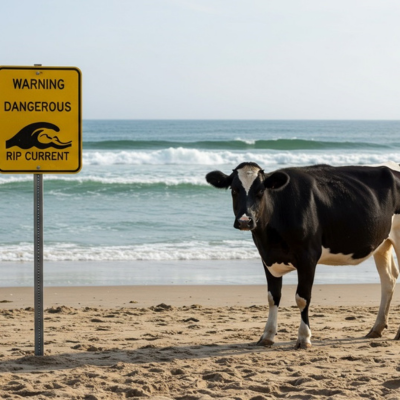

In [3]:
image_path = "../images/cow.png"
image = load_image(image_path)
image

In [4]:
image.size

(400, 400)

In [5]:
prompt = "detect cow\n"

In [6]:
formatted_prompt = apply_chat_template(
    processor, config, prompt, num_images=1
)

In [7]:
output = generate(model, processor, formatted_prompt, image, verbose=True)

Files: <PIL.Image.Image image mode=RGB size=400x400 at 0x4F78AD650> 

Prompt: <image>detect cow

<loc0409><loc0519><loc0893><loc1022> cow
Prompt: 1028 tokens, 297.821 tokens-per-sec
Generation: 6 tokens, 6.007 tokens-per-sec
Peak memory: 11.181 GB


In [8]:
print(output)

<loc0409><loc0519><loc0893><loc1022> cow


In [9]:
def parse_bbox(model_output):
    entries = model_output.split(";")
    
    results = []
    for entry in entries:
        entry = entry.strip()  # Remove leading/trailing whitespace
        # Extract the numbers from <locXXXX> tags.
        numbers = re.findall(r'<loc(\d+)>', entry)
        if len(numbers) == 4:
            bbox = [int(num) for num in numbers]
            # Remove all the <locXXXX> tags to get the label.
            label = re.sub(r'<loc\d+>', '', entry).strip().rstrip('.')
            # label = None
            results.append({'bbox_2d': bbox, 'label': label})
    
    return results

PaliGemma can detect entities in an image using the detect [entity] prompt. 

It will output the location for the bounding box coordinates in the form of 

special <loc[value]> tokens, where value is a number that represents a 

normalized coordinate. Each detection is represented by four location coordinates 

in the order y_min, x_min, y_max, x_max, followed by the label that was detected 

in that box. To convert values to coordinates, you first need to divide the 

numbers by 1024, then multiply y by the image height and x by its width. 

This will give you the coordinates of the bounding boxes, relative to the original image size.

In [10]:
def normalize_bbox(image, x_min, y_min, x_max, y_max):
    width, height = image.size
    
    print(x_min, y_min, x_max, y_max)
    x_min_norm = int(x_min / 1024 * width)
    y_min_norm = int(y_min / 1024 * height)
    x_max_norm = int(x_max / 1024 * width)
    y_max_norm = int(y_max / 1024 * height)
    print(x_min_norm, y_min_norm, x_max_norm, y_max_norm)

    return x_min_norm, y_min_norm, x_max_norm, y_max_norm

In [11]:
def plot_image_with_bboxes(image, bboxes):
    image = Image.open(image) if isinstance(image, str) else image
    _, ax = plt.subplots(1)
    ax.imshow(image)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(bboxes)))

    for i, (bbox, color) in enumerate(zip(bboxes, colors)):
        label = bbox.get("label", None)
        y_min, x_min, y_max, x_max = bbox.get("bbox_2d", None)

        x_min_norm, y_min_norm, x_max_norm, y_max_norm = normalize_bbox(
            image, x_min, y_min, x_max, y_max
        )
        width = x_max_norm - x_min_norm
        height = y_max_norm - y_min_norm

        rect = patches.Rectangle(
            (x_min_norm, y_min_norm),
            width,
            height,
            linewidth=2,
            edgecolor=color,
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            x_min_norm,
            y_min_norm,
            label,
            color=color,
            fontweight="bold",
            bbox=dict(facecolor="white", edgecolor=color, alpha=0.8),
        )

    plt.axis("off")
    plt.tight_layout()

[{'bbox_2d': [409, 519, 893, 1022], 'label': 'cow'}]
519 409 1022 893
202 159 399 348


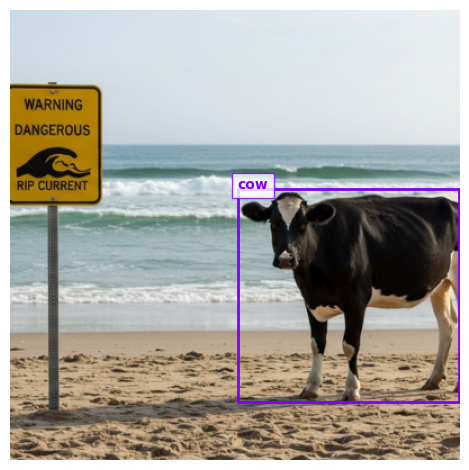

In [12]:
objects_data = parse_bbox(output)
print(objects_data)
plot_image_with_bboxes(image_path, bboxes=objects_data)

# Segmentation

In [13]:
import functools
import logging
import re
from typing import Callable, Tuple

import cv2
import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.nn as nn
import numpy as np
from mlx_vlm import apply_chat_template, generate, load
from mlx_vlm.utils import load_image
from tensorflow.io import gfile

In [14]:
logging.basicConfig()
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

In [15]:
MODEL_PATH = "mlx-community/paligemma2-3b-mix-448-bf16"
IMAGE_PATH = "../images/cow.png"
_KNOWN_MODELS = {"oi": "gs://big_vision/paligemma/vae-oid.npz"}

In [16]:
class ResBlock(nn.Module):
    def __init__(self, features: int):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=features, out_channels=features, kernel_size=3, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=features, out_channels=features, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=features, out_channels=features, kernel_size=1, padding=0
        )

    def __call__(self, x: mx.array) -> mx.array:
        original_x = x
        x = nn.relu(self.conv1(x))
        x = nn.relu(self.conv2(x))
        x = self.conv3(x)
        return x + original_x

In [17]:
class Decoder(nn.Module):
    """
    Decoder that upscales quantized vectors to produce a mask.
    The architecture is parameterized to avoid hardcoded layer definitions.
    """

    def __init__(
        self,
        in_channels: int = 512,
        res_channels: int = 128,
        out_channels: int = 1,
        num_res_blocks: int = 2,
        upsample_channels: Tuple[int, ...] = (128, 64, 32, 16),
    ):
        super().__init__()
        self.conv_in = nn.Conv2d(
            in_channels=in_channels, out_channels=res_channels, kernel_size=1, padding=0
        )
        self.res_blocks = [
            ResBlock(features=res_channels) for _ in range(num_res_blocks)
        ]
        self.upsample_layers = []
        out_up_ch = res_channels
        for ch in upsample_channels:
            self.upsample_layers.append(
                nn.ConvTranspose2d(
                    in_channels=out_up_ch,
                    out_channels=ch,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                )
            )
            out_up_ch = ch
        self.conv_out = nn.Conv2d(
            in_channels=upsample_channels[-1],
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
        )

    def __call__(self, x: mx.array) -> mx.array:
        x = nn.relu(self.conv_in(x))
        for block in self.res_blocks:
            x = block(x)
        for layer in self.upsample_layers:
            x = nn.relu(layer(x))

        return self.conv_out(x)

In [18]:
def _get_params(checkpoint: dict) -> dict:
    """Converts PyTorch checkpoint to MLX params (nested dict).
    Uses transpositions yielding (Out, H, W, In) format weights."""

    def transp(kernel: np.ndarray) -> mx.array:
        return mx.transpose(mx.array(kernel), (0, 2, 3, 1))

    def transp_transpose(kernel: np.ndarray) -> mx.array:
        intermediate = mx.transpose(mx.array(kernel), (1, 0, 2, 3))

        return mx.transpose(intermediate, (0, 2, 3, 1))

    def conv(name: str) -> dict:
        return {
            "bias": mx.array(checkpoint[f"{name}.bias"]),
            "weight": transp(checkpoint[f"{name}.weight"]),
        }

    def conv_transpose(name: str) -> dict:
        return {
            "bias": mx.array(checkpoint[f"{name}.bias"]),
            "weight": transp_transpose(checkpoint[f"{name}.weight"]),
        }

    def resblock(name: str) -> dict:
        return {
            "conv1": conv(f"{name}.0"),
            "conv2": conv(f"{name}.2"),
            "conv3": conv(f"{name}.4"),
        }

    params = {
        "_embeddings": mx.array(checkpoint["_vq_vae._embedding"]),
        "conv_in": conv("decoder.0"),
        "res_blocks": [
            resblock("decoder.2.net"),
            resblock("decoder.3.net"),
        ],
        "upsample_layers": [
            conv_transpose("decoder.4"),
            conv_transpose("decoder.6"),
            conv_transpose("decoder.8"),
            conv_transpose("decoder.10"),
        ],
        "conv_out": conv("decoder.12"),
    }

    return params

In [19]:
def _quantized_values_from_codebook_indices(
    codebook_indices: mx.array, embeddings: mx.array
) -> mx.array:
    batch_size, num_tokens = codebook_indices.shape
    expected_tokens = 16
    if num_tokens != expected_tokens:
        log.error(f"Expected {expected_tokens} tokens, got {codebook_indices.shape}")

    encodings = mx.take(embeddings, codebook_indices.reshape((-1,)), axis=0)

    return encodings.reshape((batch_size, 4, 4, embeddings.shape[1]))

In [20]:
@functools.cache
def get_reconstruct_masks(model: str) -> Callable[[mx.array], mx.array]:
    """Loads the checkpoint and returns a function that reconstructs masks
    from codebook indices using a preloaded MLX decoder.
    """
    checkpoint_path = _KNOWN_MODELS.get(model, model)
    with gfile.GFile(checkpoint_path, "rb") as f:
        checkpoint_data = dict(np.load(f))

    params = _get_params(checkpoint_data)
    embeddings = params.pop("_embeddings")
    log.info(f"VAE embedding dimension: {embeddings.shape[1]}")

    decoder = Decoder()
    decoder.update(params)

    def reconstruct_masks(codebook_indices: mx.array) -> mx.array:
        quantized = _quantized_values_from_codebook_indices(
            codebook_indices, embeddings
        )
        return decoder(quantized)

    return reconstruct_masks

In [21]:
def extract_and_create_array(pattern: str) -> mx.array:
    """Extracts segmentation tokens from the pattern and returns them as an MLX array."""
    seg_tokens = re.findall(r"<seg(\d{3})>", pattern)
    seg_numbers = [int(token) for token in seg_tokens]

    return mx.array(seg_numbers)

In [22]:
model, processor = load(MODEL_PATH)
config = model.config

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

In [23]:
image = load_image(IMAGE_PATH)
image.size

(400, 400)

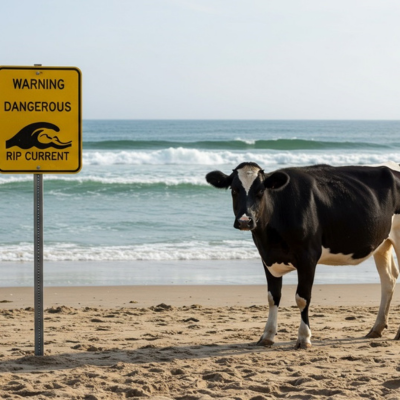

In [24]:
image

In [25]:
prompt = "segment cow\n"
formatted_prompt = apply_chat_template(processor, config, prompt, num_images=1)
output = generate(model, processor, formatted_prompt, image, verbose=True)

Files: <PIL.Image.Image image mode=RGB size=400x400 at 0x340645CD0> 

Prompt: <image>segment cow

<loc0415><loc0520><loc0890><loc1023><seg122><seg055><seg061><seg055><seg104><seg009><seg096><seg083><seg103><seg041><seg103><seg019><seg100><seg084><seg091><seg045>
Prompt: 1028 tokens, 200.018 tokens-per-sec
Generation: 21 tokens, 5.026 tokens-per-sec
Peak memory: 12.134 GB


In [26]:
print(output)

<loc0415><loc0520><loc0890><loc1023><seg122><seg055><seg061><seg055><seg104><seg009><seg096><seg083><seg103><seg041><seg103><seg019><seg100><seg084><seg091><seg045>


In [27]:
vae_path = _KNOWN_MODELS.get("oi")
reconstruct_fn = get_reconstruct_masks(vae_path)

2025-04-09 00:05:08.348416: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
INFO:__main__:VAE embedding dimension: 512


In [28]:
codes = extract_and_create_array(output)
codes.tolist()

[122, 55, 61, 55, 104, 9, 96, 83, 103, 41, 103, 19, 100, 84, 91, 45]

In [29]:
codes_batch = codes[None, :]
codes_batch.shape

(1, 16)

In [30]:
masks = reconstruct_fn(codes_batch)
masks.shape

(1, 64, 64, 1)

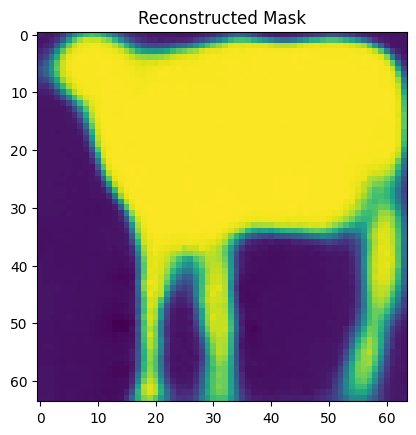

In [31]:
mask_np = np.array(masks[0, :, :, 0], copy=False)
plt.imshow(mask_np, cmap="viridis")
plt.title(f"Reconstructed Mask")
plt.axis("on")
plt.show()

In [32]:
def parse_bbox(model_output):
    entries = model_output.split(";")
    
    results = []
    for entry in entries:
        entry = entry.strip()
        numbers = re.findall(r'<loc(\d+)>', entry)
        if len(numbers) == 4:
            bbox = [int(num) for num in numbers]
            results.append(bbox)
    
    return results

In [33]:
y_min, x_min, y_max, x_max = parse_bbox(output)[0]
y_min, x_min, y_max, x_max

(415, 520, 890, 1023)

In [34]:
target_width, target_height = 448, 448
x_min_norm = int(x_min / 1024 * target_width)
y_min_norm = int(y_min / 1024 * target_height)
x_max_norm = int(x_max / 1024 * target_width)
y_max_norm = int(y_max / 1024 * target_height)
x_min_norm, y_min_norm, x_max_norm, y_max_norm

(227, 181, 447, 389)

In [35]:
width = x_max_norm - x_min_norm
height = y_max_norm - y_min_norm
width, height
# rect = patches.Rectangle(
#     (x_min_norm, y_min_norm),
#     width,
#     height,
#     linewidth=2,
#     edgecolor=color,
#     facecolor="none",
# )
# ax.add_patch(rect)

(220, 208)

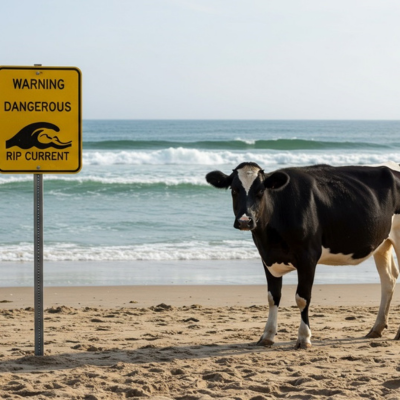

In [36]:
image_path = "../images/cow.png"
image = load_image(image_path)
image

In [37]:
image.size

(400, 400)

In [38]:
processor.image_processor(image)["pixel_values"][0].transpose(1, 2, 0).shape

(448, 448, 3)

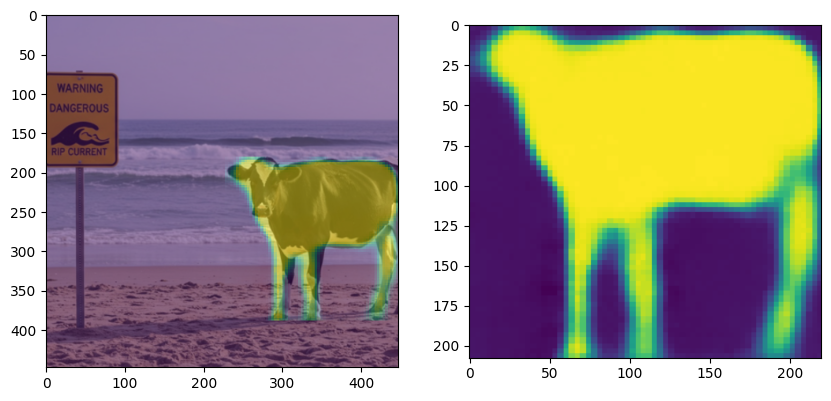

In [39]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10, 6), sharex=False)

img_array = processor.image_processor(image)["pixel_values"][0].transpose(1, 2, 0)
img_array = (img_array * 0.5 + 0.5).clip(0, 1)

width = x_max_norm - x_min_norm
height = y_max_norm - y_min_norm
rect = patches.Rectangle(
    (x_min_norm, y_min_norm),
    width,
    height,
    linewidth=2,
    edgecolor="red",
    facecolor="none",
)
# axs[0].add_patch(rect)

resized_mask = cv2.resize(np.array(masks[0]), (width, height), interpolation=cv2.INTER_NEAREST)
resized_mask = resized_mask.reshape((height, width, 1))

full = np.ones((448, 448, 1))*(-1)
h_, w_, _ = resized_mask.shape
full[y_min_norm:y_max_norm, x_min_norm:x_max_norm] = resized_mask
axs[0].imshow(img_array)
axs[1].imshow(resized_mask)
axs[0].imshow(full, alpha=0.5)